## Ideas to improve the performance:
- PCA do we really need all the components?
- Hyper parameter tuning
- Feature engineering as done here : https://appliedmachinelearning.blog/2017/11/14/spoken-speaker-identification-based-on-gaussian-mixture-models-python-implementation/

In [1]:
import os

def set_envrionment():
    google_colab = input('Are you using google colab or local jupyter notebook?\nPlease type yes or no.\nYour answer: ')
    if google_colab=='yes':
        from google.colab import drive

# This will prompt for authorization.
        drive.mount('/content/drive')

# Change to assignment directory ('Lab_Exercises_DASS/Lab_Exercise1' by default)
        repository_dir = '/content/drive/My Drive/University/UC3M/bi_semester_4/smart_society'
    
        os.chdir(repository_dir)
    else:
        repository_dir = os.getcwd().replace('/code','')
        
    data_dir = repository_dir + '/' + 'data'
    code_dir = repository_dir + '/' + 'code'
    image_dir = repository_dir + '/' + 'notes' + '/' + 'images'
    
    return repository_dir, data_dir, code_dir, image_dir
repository_dir, data_dir, code_dir, image_dir = set_envrionment()
    

Are you using google colab or local jupyter notebook?
Please type yes or no.
Your answer: 


In [2]:
import numpy  as np
import matplotlib.pyplot as plt
import librosa  # package for speech and audio analysis
from sklearn import mixture
from sklearn.metrics import accuracy_score,confusion_matrix
plt.style.use('default')
from IPython.display import Image

seed = 0

In [3]:
nomlist_train = 'Train_List.txt';
nomlist_test = ['Test_List1.txt', 'Test_List2.txt']
print("Training list: " + nomlist_train)
print("Test list 1 (clean conditions): "+ nomlist_test[0])
print("Test list 2 (noisy conditions): "+ nomlist_test[1])

Training list: Train_List.txt
Test list 1 (clean conditions): Test_List1.txt
Test list 2 (noisy conditions): Test_List2.txt


### Sampling Rate
The sampling rate --- typically fs in the digital signal processing literature, or sr in librosa --- is defined as 1/ts, where ts is the amount of time (in seconds) between successive samples. Equivalently, fs is the number of observations per second in the discretely sampled signal

Source: https://librosa.github.io/

speechdata/irm01/irm01_s01_test1.wav
Number of samples in file speechdata/irm01/irm01_s01_test1.wav = 41386
Sampling frequency = 16000 Hz


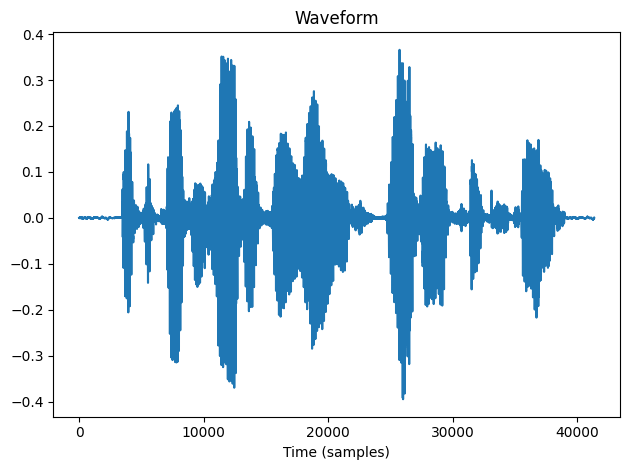

In [4]:
# Reading a speech file from the database
# --------------------------------------------------------------------
sample = 'speechdata/irm01/irm01_s01_test1.wav'
speech_name = data_dir + '/' + sample
print(sample)

# x: speech signal : time series as numpy array

# fs: sampling frequency
x, fs = librosa.load(speech_name, sr=None)
print("Number of samples in file " +sample+" = "+str(x.shape[0]))
print("Sampling frequency = "+str(fs)+" Hz")

fig, ax = plt.subplots()
plt.plot(x)
plt.title('Waveform')
ax.set_xlabel('Time (samples)')
plt.tight_layout()
plt.show()
plt.close()

In the following, we show an example of feature extraction for the previous speech signal *x*.

In particular, we want to compute a set of mel-frequency cepstrum coefficients (MFCC) with the following configuration:

* Size of the analysis window = 20 ms

* Frame period or hop length = 10 ms

* Number of filters in the mel filterbank = 40

* Number of MFCC components = 20

For doing that, we are going to use the function **mfcc** from the module *feature* of the *librosa* package. This function has, among others, the following input arguments:

* y: speech signal 
* sr: sampling frequency
* n_fft: window size (in samples)
* hop_length: frame period or hop length (in samples)
* n_mels: number of filters in the mel filterbank
* n_mfcc: number of MFCC components

Note that in this function the window size and the hop length must be expressed in samples. Taking into account that the sampling frequency (fs) indicates that 1 second correspond to fs samples (in our case, as fs=16 kHz, 1 second corresponds to 16000 samples), the conversion from **seconds** to **samples** is performed by:

```
samples = seconds*fs = seconds*16000
```

With the previous information, fill the values of the configuration variables in the next code.



In [5]:
def calc_window_size(fs,window_size_in_ms=20):
    return int(fs/1000*window_size_in_ms)
def calc_hop_length(fs, hop_lenght_in_ms=10):
    return int(fs/1000*hop_lenght_in_ms)

In [6]:
# --------------------------------------------------------------------
# Configuration variables for feature extraction
# --------------------------------------------------------------------

##################################
# - FILL THE VALUES OF THE FOLLOWING CONFIGURATION VARIABLES
##################################

wst = 1/1000*20       # Window size (seconds)
fpt = 1/1000*10       # Frame period (seconds) 
nfft = calc_window_size(fs)      # Window size (samples)
fp = calc_hop_length(fs)        # Frame period (samples)
nbands = 40    # 
ncomp = 20     # Number of MFCC components

The dimensions of the resulting MFCC must be,

```
(ncomp x T)
```

being *T* the number of frames of the speech signal, which is computed as the number of samples of the speech signal divided by the hop length (in samples), rounded off to the ceil integer.

The following code computes the MFCC features considering the previously configured variables.

Check the dimensions of the resulting MFCC features.


In [7]:
# --------------------------------------------------------------------
# Example of MFCC computation
# --------------------------------------------------------------------

# Feature extraction (MFCC computation)
mfcc = librosa.feature.mfcc(y=x,
                            sr=fs,
                            n_fft=nfft,
                            hop_length=fp,
                            n_mels=nbands,
                            n_mfcc=ncomp)

seconds_of_snippet = librosa.core.get_duration(x,sr=fs)
T = seconds_of_snippet/fpt
print('The audio file is of lenght {} seconds.\nGiven the sampling rate of {}\and a hop length of {} we should see {} dimensions'.format(
        round(seconds_of_snippet,2),fs, fpt, round(T))
)
print('The dimensions of the mfcc object are {} by {}'.format(mfcc.shape[0], 
                                                              mfcc.shape[1]))

The audio file is of lenght 2.59 seconds.
Given the sampling rate of 16000nd a hop length of 0.01 we should see 259 dimensions
The dimensions of the mfcc object are 20 by 259


## Theoretical understanding of Gaussian Mixture Models

__Gaussian Mixture Models -  Under the hood__:
Given a number of components Gaussian Mixtures attempt to maximize the the liklihood, that the data belongs to a normal distribution. 

Therefore it is not so much a clustering but an estimator of the overall density.

__Hyperparameters:__
- covariance_type: The covariance type for each component.
The covariance controls the spread of the data, i.e. in one or in the multivariate case in n directions. It thus determines the possible size of a component. Moreover, the type of covariance constrains the shape of the cluster. I.e. diagonal means that the cluster and only expand along the axis since the covariance entries are zero. Speherical constrains the covariance matrix to a spehre.

- n_components:
The components is number of Gaussian distributions that we believe the data was generated from.
In the Moon example although there are clearly two clusters, a good choice seems to be 16 components. Some components have a very narrow kernel while others are wide. $$N~(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi * \sigma^2}}*exp((\frac{x-\mu)^2}{2\sigma}))$$ This means that some of these components have a large and other a small standard deviation.

In the third picture the author drew 25 from the 16 multivariate Gaussian thus getting 400 points which model the data very well.

So in our case we use 8 components but we are building 16 different models. This is akin to saying that the voice snippet can be modelled with 8 components. Thus at test times we maximize the Liklihood with all 16 models and pick the label of the one that maximizes the likelihood.

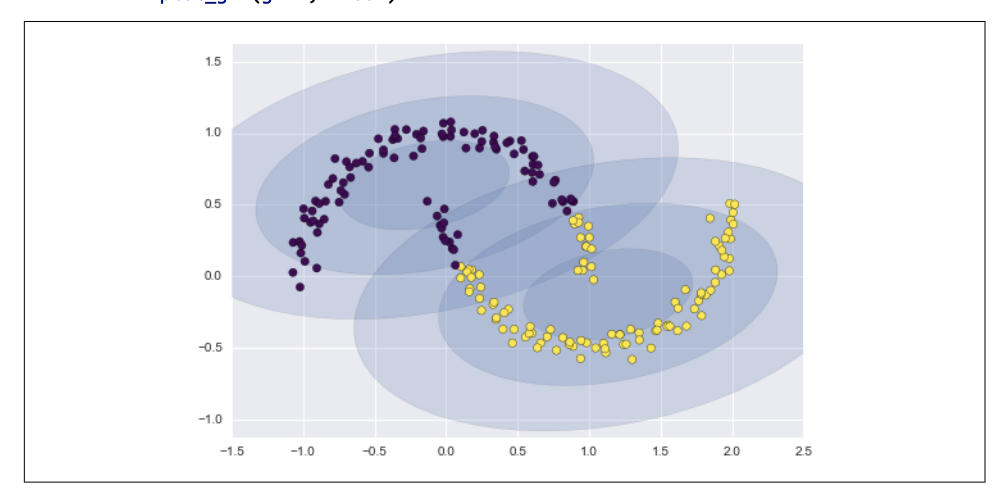

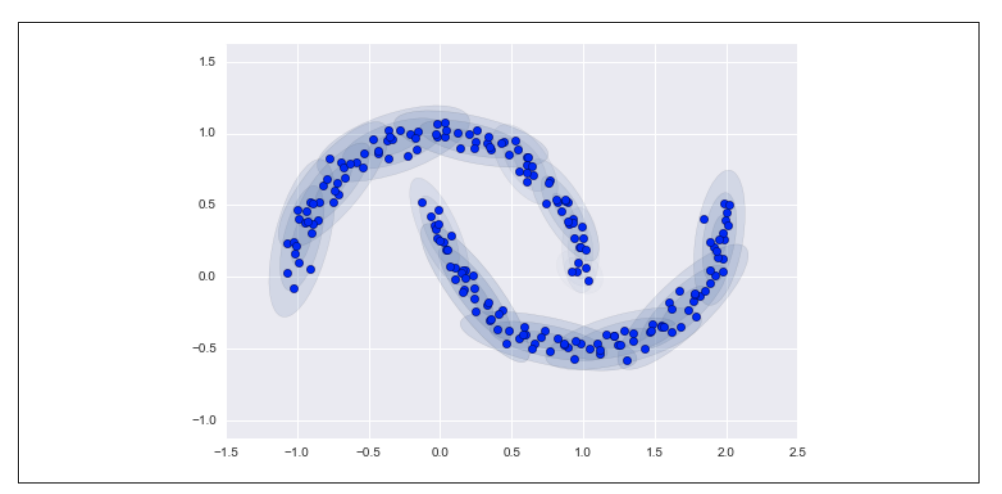

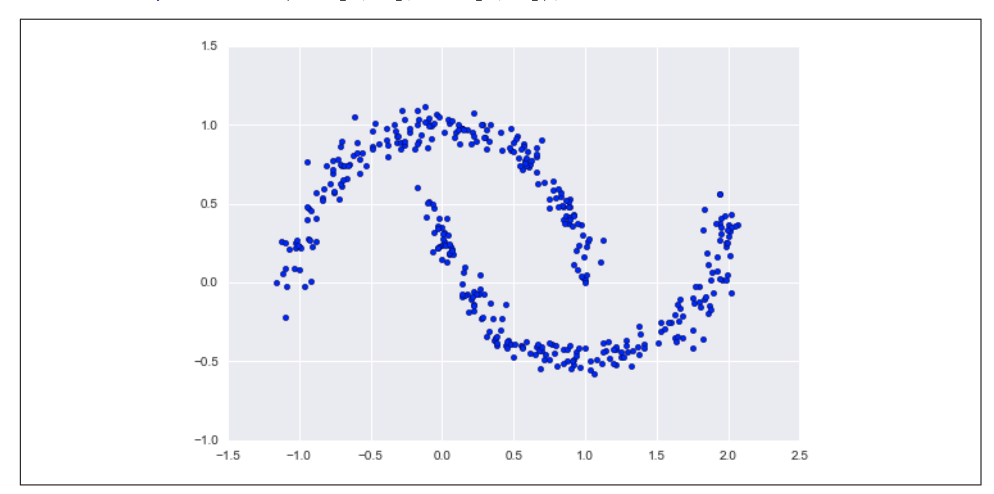

In [8]:
imgs = ['16comp_moondatacluster.png','16comp_moondata.png','16comp_sampling.png']
for img in (imgs):
    file = Image(image_dir + '/' + img)
    display(file)
    

## Training the Gaussian Mixture Models

In [9]:
ngauss = 8

In [10]:
def load_n_preprocess(filename,directory=data_dir):
    with open (directory + '/' + filename) as f:
        content = f.readlines()
    nspk = len(content)

    data = np.array([line.strip().split(' ') for line in content])
    files_speech_train = data[:,0]
    labels_train = data[:,1].astype(np.int16)
    return nspk, files_speech_train, labels_train

In [11]:
nspk, files_speech_train,labels_train = load_n_preprocess('Train_List.txt')

In [58]:
def extract_data(data_dir,
                 labels,
                 files_speech,
                 sr=None):
    return [{
        'label': label,
        'raw_data':librosa.load(data_dir + '/' + file, sr=sr)[0],
        'sr':librosa.load(data_dir + '/' + file, sr=sr)[1]}
        for label, file in zip(labels,files_speech)]

In [13]:
def extract_features(data_dict,
                     window_size=wst,
                     frame_period=fpt,
                     nbands=nbands,
                     ncomp=ncomp):
    for dic in data_dict:
        x = dic['raw_data']
        fs = dic['sr']
        nfft = calc_window_size(fs)    
        fp = calc_hop_length(fs)
        mfcc = librosa.feature.mfcc(y=x,
                            sr=fs,
                            n_fft=nfft,
                            hop_length=fp,
                            n_mels=nbands,
                            n_mfcc=ncomp)
        dic['mfcc_features'] = mfcc
    
    return data_dict
        

In [18]:
def train_models(params,
                 data_dir=data_dir,
                 labels=labels_train,
                 files_speech=files_speech_train,
                 sr=None):
    all_data = extract_data(data_dir,
                            labels,
                            files_speech,
                            sr)
    
    all_data = extract_features(all_data)
    index = 0
    for dic in all_data:
        dic['model'] = (mixture.GaussianMixture(**params))
        try:
            dic['model'].fit(np.transpose(dic['mfcc_features']))
        except ValueError:
            print('Change "reg_covar for model {}"'.format(index))
        finally:
            index += 1
    return all_data

In [19]:
trained_models = train_models(params={
    'n_components':ngauss,
    'covariance_type':'diag',
    'n_init':1,
    'random_state':seed,
    'reg_covar':1e-2
})

## Testing the Gaussian Mixture Models

####  Clean conditions

In [20]:
nspk_test, files_speech_test,labels_test = load_n_preprocess('Test_List1.txt')

In [49]:
def calc_accuracy(test_data):
    denom = len(test_data)
    nominator =  sum([entry['label']==entry['predicted_label']for entry in test_data])
    return round(100*nominator/denom,2)

In [56]:
def test_models(trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=None):
    test_data = extract_data(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
    
    test_data = extract_features(test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(np.transpose(snippit['mfcc_features'])) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

In [57]:
tested_models,accuracy_cleandata = test_models(trained_models,
                                                data_dir,
                                                labels_test,
                                                files_speech_test)

160


In [55]:
print('The test accuracy on the clean test data is: {}'.format(accuracy_cleandata))

The test accuracy on the clean test data is: 98.75


#### Noisy conditions

In [34]:
nspk_test_noise, files_speech_test_noise,labels_test_noise = load_n_preprocess('Test_List2.txt')

In [35]:
tested_models_noise,accuracy_noisedata = test_models(trained_models,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)

In [36]:
print('The test accuracy on the clean test data is: {}'.format(accuracy_noisedata))

The test accuracy on the clean test data is: 100.0
